# MOHD AFTAB SALIM SHAIKH

Customer Segmentation using K-Means Clustering

# STEP 1 : DATA COLLECTION

Overview of the Project :

Segmenting customers based on their spending behavior is an important practice in business segmentation. This project applies unsupervised learning to segment customers using K-Means Clustering, along with Agglomerative Hierarchical Clustering and DBSCAN for comparative analysis. Unsupervised learning is chosen because there are no predefined labels in the dataset, the aim is to classify customers into distinct categories without any prior hypothesis.

The dataset was obtained from the UCI Machine Learning Repository [1], which hosts the Online Retail dataset with 541,909 records of an e-commerce company situated in the UK with details of each transaction such as items bought and customer ID. The dataset underwent preprocessing which included missing values treatment, normalization of numeric features and feature construction using RFM (Recency, Frequency, and Monetary) analysis. Clustering is enhanced by feature selection and classification, (a) filtering with correlation analysis, (b) embedding with PCA, and (c) wrapping with Recursive Feature Elimination.

Three clustering models are trained, with hyperparameter tuning applied using the Elbow Method and Silhouette Analysis to optimize the number of clusters. The models are evaluated using Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index and Gap Statistics Analysis ensuring robust performance assessment. Additionally, the impact of cross-validation and hyperparameter tuning on clustering quality is examined.

The results reveal distinct customer segments, aiding businesses in targeted marketing strategies and personalized customer interactions. The study highlights the significance of unsupervised learning in discovering hidden patterns, demonstrating the advantages of different clustering approaches. The findings contribute to improved business decision-making and customer relationship management.

Citation

[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Online Retail Dataset. Available at: https://archive.ics.uci.edu/ml/datasets/Online+Retail


The dataset used for this project is the Online Retail Dataset from the UCI Machine Learning Repository, containing 541,909 transactions recorded between December 1, 2010, and December 9, 2011. It is an unlabeled dataset which consists of eight features, i.e invoice number, stock code, product description, quantity, invoice date, unit price, customer ID, and country.

This is an unsupervised learning task, thus there is no predefined labels, and the aim is to segment customers based on their purchasing behavior. This dataset includes a mix of feature types: categorical features such as InvoiceNo, StockCode, CustomerID, and Country; numerical features such as Quantity and UnitPrice; and a datetime feature (InvoiceDate).

The dataset is publicly available at the UCI Machine Learning Repository and can be accessed via this link:
https://archive.ics.uci.edu/dataset/352/online+retail

I have downloaded the dataset and uploaded that on a Drive Folder, under the name ML Midterm project, I will mount my colab file with my drive and proceed with Pre-processing and feature engineering

# STEP 2 : DATA PRE-PROCESSING

In [ ]:
#Mounting my colab file to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Navigating to my dataset on the drive

import pandas as pd

# Define the file path
file_path = '/content/drive/My Drive/ML_Midterm_Project/Online_Retail.xlsx'

# Load the dataset
df = pd.read_excel(file_path)

# Display the first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
#checking for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


We can see that description has 1454 missing values, customerID has 135080 missing values,

We will drop the description column since it is not very important for clustering, and we will remove rows in the CustomerID which have missing value

In [ ]:
# Drop rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

# Drop the Description column (not needed for clustering)
df = df.drop(columns=['Description'])

# Check again for missing values
print("Missing Values after cleaning:\n", df.isnull().sum())

Missing Values after cleaning:
 InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [ ]:
#Removing duplicate values, since transactions may be duplicated in the dataset.
df = df.drop_duplicates()

# Check the shape of the dataset after removing duplicates
print("Dataset shape after removing duplicates:", df.shape)

Dataset shape after removing duplicates: (401602, 7)


In [ ]:
#To make sure data quality is good, we should remove invalid transactions i.e
# transactions where Quantity <= 0 (Negative values may indicate cancellations)
# transactions where UnitPrice <= 0 (Pricing errors)


# Remove rows where Quantity or UnitPrice is zero or negative
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Check dataset shape after filtering
print("Dataset shape after removing invalid transactions:", df.shape)


Dataset shape after removing invalid transactions: (392690, 7)


This section describes how we filtered the data set before analysis by correcting the missing values, duplicates and errors in the data set. We deleted the rows which had missing CustomerID and eliminated records where Quantity and UnitPrice had zero or negative values. Additionally, the column InvoiceDate was changed to the datetime data type for more advanced feature engineering. These necessities make the information presentable before extraction features and clustering analysis.

# STEP 3 : FEATURE ENGINEERING

Feature engineering is a important step in ML that involves creating new meaningful features from raw data to enhance model performance. In this section, we extract key features that help in customer segmentation. We compute TotalPrice to represent the total amount spent per transaction and perform Recency, Frequency, and Monetary (RFM) Analysis to quantify customer behavior. Additionally, we handle outliers to prevent extreme values from disturbing clustering results and apply feature scaling to normalize the dataset for better clustering performance. These transformed features will be used in the next step to group similar customers into meaningful segments.

In [ ]:
#We will make sure that the InvoiceDate is in a proper datetime format so we can use it for recency analysis.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Confirm the data type
print("InvoiceDate data type:", df['InvoiceDate'].dtype)

InvoiceDate data type: datetime64[ns]


Now we will create two important feature Quantity and UnitPrice, and store it under TotalPrice,

We are doing this in order to calculate RFM (Recency, Frequency, Monetary) Features which stands for

Recency (R) - How many days since the last purchase?

Frequency (F) - How many unique purchases per customer?

Monetary (M) - How much has each customer spent in total?


In [ ]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Display the first few rows
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
import datetime

# Setting the refeence date one day prior to the last transaction
reference_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

# Print reference date
print("Reference Date for Recency Calculation:", reference_date)

Reference Date for Recency Calculation: 2011-12-10 12:50:00


In [ ]:
# We will group the dataframe by CustomerID and calculate RFM
rfm = df.groupby('CustomerID').agg({
    # Recency (days since last purchase)
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    # Frequency (number of unique purchases)
    'InvoiceNo': 'nunique',
    # Monetary (total spending)
    'TotalPrice': 'sum'
})

# Renaming columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Display summary
print("RFM Table Preview:\n", rfm.head())

RFM Table Preview:
             Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


We can see from the RFM table that Customer 12347 is a recent and frequent buyer (Recency = 2 days, Frequency = 7 purchases).

Customer 12346 has not purchased for 326 days but has spent the most (Monetary = £77,183.60).

Customer 12349 made only 1 purchase and spent £1,757.55, indicating a one-time high-value customer.

Now we will detect and handle outliers in here if any found.

In [ ]:
import numpy as np

# Defining a function to detect outliers
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].shape[0]

# Check outliers for each RFM feature
print("Outliers in Recency:", detect_outliers(rfm, 'Recency'))
print("Outliers in Frequency:", detect_outliers(rfm, 'Frequency'))
print("Outliers in Monetary:", detect_outliers(rfm, 'Monetary'))

Outliers in Recency: 155
Outliers in Frequency: 285
Outliers in Monetary: 425


We have detected outliers in the RFM table and it's important to handle them because K-Means assigns data points to clusters based on their centroid distance and extreme outliers can pull the cluster centroids far away, disturbing cluster assignments.

Eg : A customer who spent £100,000 (while most customers spend less than £5,000) will shift the cluster centroid, making the segmentation meaningless.

We will handle these by capping the extreme values also knows as winsorizing.

In [ ]:
# Apply capping to limit outliers at 1st and 99th percentiles
for col in ['Recency', 'Frequency', 'Monetary']:
    lower_bound = rfm[col].quantile(0.01)  # 1st percentile
    upper_bound = rfm[col].quantile(0.99)  # 99th percentile
    rfm[col] = np.clip(rfm[col], lower_bound, upper_bound)

# Check the summary after capping
print("Summary after handling outliers:\n", rfm.describe())

Summary after handling outliers:
            Recency    Frequency      Monetary
count  4338.000000  4338.000000   4338.000000
mean     92.500692     4.008760   1592.640811
std      99.914624     4.863497   2788.352940
min       1.000000     1.000000     52.200000
25%      18.000000     1.000000    306.482500
50%      51.000000     2.000000    668.570000
75%     142.000000     5.000000   1660.597500
max     369.000000    30.000000  19780.487800


In [ ]:
# We will apply Min-Max scaling to ensure the range is bought to 0-1
# And no single RFM fetaure dominates the clustering
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to RFM features
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to a DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'], index=rfm.index)

# Display summary
print("Scaled RFM Table Preview:\n", rfm_scaled.head())

Scaled RFM Table Preview:
              Recency  Frequency  Monetary
CustomerID                               
12346.0     0.883152   0.000000  1.000000
12347.0     0.002717   0.206897  0.215822
12348.0     0.201087   0.103448  0.088454
12349.0     0.048913   0.000000  0.086442
12350.0     0.839674   0.000000  0.014304


Now one final thing which remains in feature engineering is feature selection before clustering

We will apply three feature selection techniques

1. Filtering Method: Correlation Analysis
2. Embedding Method: PCA (Principal Component Analysis)
3. Wrapping Method: Recursive Feature Elimination (RFE)

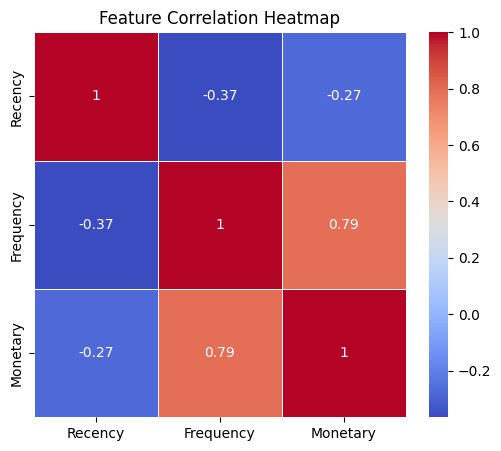

In [ ]:
#We will first analyze correlation to identify redundant features.
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = rfm.corr()

# Plot the heatmap
plt.figure(figsize=(6,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

from the heatmap we can see that

Recency vs Frequency -> -0.37 (low correlation)

Recency vs Monetary -> -0.27 (low correlation)

Frequency vs Monetary -> 0.79 (moderate to high correlation)

The usual upper limit for correlation is 0.85 since none of the feature surpasss those we will not remove anything at this stage

In [ ]:
# Now, we will apply PCA to reduce dimensionality while keeping the important information
from sklearn.decomposition import PCA

# Apply PCA to RFM features
pca = PCA(n_components=2)  # Reduce to 2 components
rfm_pca = pca.fit_transform(rfm_scaled)

# Convert to DataFrame
rfm_pca_df = pd.DataFrame(rfm_pca, columns=['PCA1', 'PCA2'], index=rfm.index)

# Check explained variance
print("Explained Variance by PCA Components:", pca.explained_variance_ratio_)

Explained Variance by PCA Components: [0.68396169 0.27661656]


Explanation of My PCA analysis

From the analysis we can see that

PCA1 explains 68.4% of the data’s variance

PCA2 explains 27.7% of the data’s variance & the total variance explained becomes a whopping 95.9%

This means that instead of using RFM features for clustering we can use PCA1 and PCA2 as it still has the most important features preserved from the dataset.

But we will verify this using Recursive Feature Elimination, If RFE agrees with PCA, we will be using PCA1 & PCA2 for clustering

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Create a temporary target variable for RFE (since RFE requires labels)
# Dummy target variable only for RFE ranking
rfm['Target'] = 0

# Initialize a model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select the top 2 features
selector = RFE(model, n_features_to_select=2)
selector.fit(rfm.drop(columns=['Target']), rfm['Target'])

# Get selected feature names
selected_features = rfm.drop(columns=['Target']).columns[selector.support_]
print("Selected Features after RFE:", list(selected_features))

# Drop the temporary target column
rfm.drop(columns=['Target'], inplace=True)

Selected Features after RFE: ['Frequency', 'Monetary']


We can see that RFE has selected Frequency and Monetary as the most important features, which means Recency was not selected because it may contribute less to customer segmentation than Frequency & Monetary.

PCA used all three features to create PCA1 & PCA2, while RFE directly selected two features.

I will go with RFE selected features (Frequency & Monetary) for clustering because, they are easier to interpret in a business context and it directly selects the most relevant features

In [ ]:
#This is the final code which we will use for clustering
#Keeping only the selected RFE features for clustering
rfm_final = rfm[['Frequency', 'Monetary']]

# Display the first few rows
print(rfm_final.head())

            Frequency    Monetary
CustomerID                       
12346.0             1  19780.4878
12347.0             7   4310.0000
12348.0             4   1797.2400
12349.0             1   1757.5500
12350.0             1    334.4000


At the end of this section we have done

Filtering (Correlation Analysis) -> We initially checked multi-collinearity using a heatmap, since no features had a correlation above 0.85, we kept all features for time being

Embedding (PCA - Principal Component Analysis) -> PCA reduced the dataset from 3 features to 2 components, retaining 95.9% of the variance.

Wrapping (RFE - Recursive Feature Elimination) -> RFE selected Frequency and Monetary as the most important features for clustering.

# STEP 4 : FINDING OPTIMAL NUMBER OF CLUSTERS

Before applying K-Means clustering, we need to determine the best number of clusters i.e K

For that we will be using

Elbow Method -> It helps find the optimal K by analyzing WCSS (Within-Cluster Sum of Squares).

Silhouette Score -> It measures how well-separated the clusters are



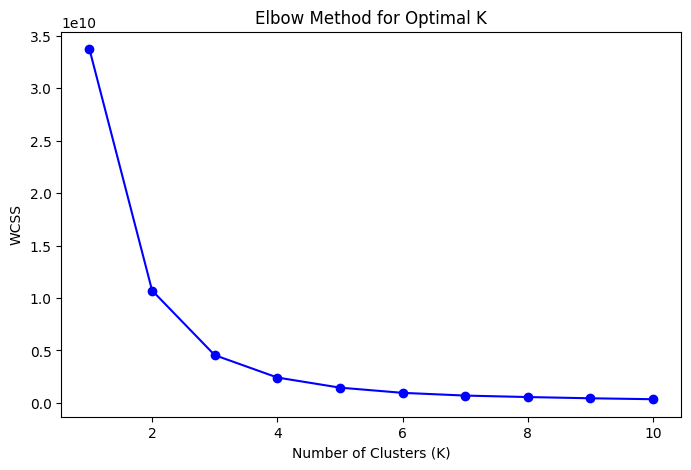

In [ ]:
# The Elbow Method plots the Within-Cluster Sum of Squares (WCSS) for different values of K.
# We look for the “elbow point” where the curve starts to flatten, indicating the best K.

from sklearn.cluster import KMeans

# Finding the optimal number of clusters using the Elbow Method
# Store Within-Cluster Sum of Squares for each K
wcss = []

# Trying different values of K (number of clusters)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
    kmeans.fit(rfm_final)
    #Inertia here means WCSS
    wcss.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

Silhouette Score for K=2: 0.8767
Silhouette Score for K=3: 0.7529
Silhouette Score for K=4: 0.7153
Silhouette Score for K=5: 0.6744
Silhouette Score for K=6: 0.6592
Silhouette Score for K=7: 0.6253
Silhouette Score for K=8: 0.6157
Silhouette Score for K=9: 0.5925
Silhouette Score for K=10: 0.5892


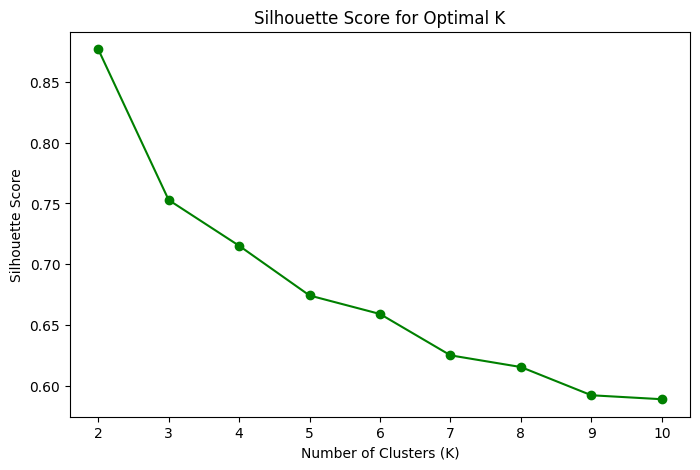

In [ ]:
# The Silhouette Score measures how well-separated the clusters are
# A higher silhouette score means better-defined clusters

from sklearn.metrics import silhouette_score

# Checking Silhouette Scores for different values of K
silhouette_scores = {}

 # K must be at least 2
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
    labels = kmeans.fit_predict(rfm_final)
    score = silhouette_score(rfm_final, labels)
    silhouette_scores[k] = score
    print(f"Silhouette Score for K={k}: {score:.4f}")

# Plot the Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

Based on the plots we can see that,

In Elbow method plot the curve shows a sharp drop until K = 3, and then it starts to flatten which means the elbow point appears to be at K = 3 or K = 4

In Silhouette Score plot, The highest silhouette score is for K = 2 (0.8767), K =3  has a silhouette score of 0.7529 which is a good balance between cluster separation and meaningful grouping.

We will go ahead with K = 3 because it gives us a good balance between WCSS reduction & silhouette score.

# STEP 5 : MODEL TRAINING (CLUSTERING)

Clustering is a important technique in unsupervised learning that groups similar data points together without predefined labels. In this section, we are going too apply K-Means Clustering, it is a distance-based clustering algorithm, to segment customers based on their purchasing behavior. Using the optimal number of clusters (K=3) decided in the previous section, we will assign each customer to a cluster and analyze the results.

Also, we will also use Hierarchical Clustering (Agglomerative) and DBSCAN (Density-Based Clustering) to compare their performance with K-Means. By segmenting customers into meaningful groups, businesses can develop targeted marketing strategies and enhance customer relationship management.

            Frequency    Monetary  Cluster  Cluster_Hierarchical  \
CustomerID                                                         
12346.0             1  19780.4878        1                     2   
12347.0             7   4310.0000        2                     0   
12348.0             4   1797.2400        0                     0   
12349.0             1   1757.5500        0                     0   
12350.0             1    334.4000        0                     0   

            Cluster_DBSCAN  
CustomerID                  
12346.0                  0  
12347.0                  1  
12348.0                  1  
12349.0                  1  
12350.0                  1  
Cluster sizes:
 Cluster
0    3698
2     539
1     101
Name: count, dtype: int64


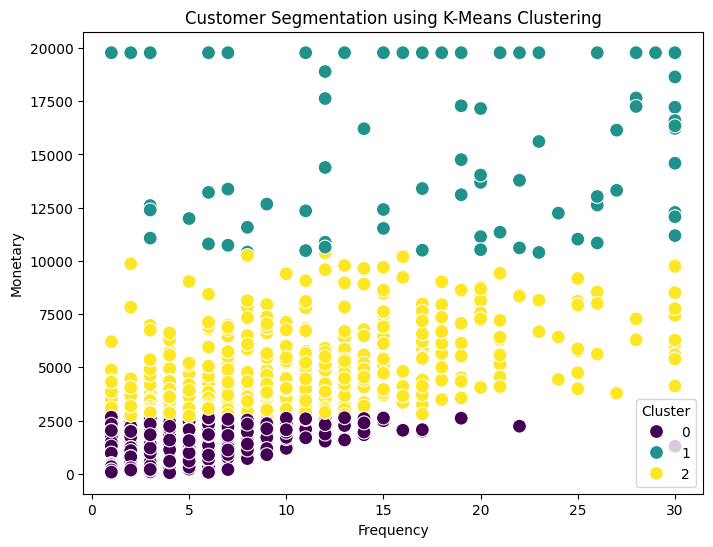

In [ ]:
#Training the K-Means model with K=3 and analyze the clusters

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=42)
rfm_final['Cluster'] = kmeans.fit_predict(rfm_final)

# Print the first few rows with cluster labels
print(rfm_final.head())

# Check the cluster sizes
print("Cluster sizes:\n", rfm_final['Cluster'].value_counts())

#Lets visualize the clusters for a better understanding
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm_final['Frequency'], y=rfm_final['Monetary'], hue=rfm_final['Cluster'], palette='viridis', s=100)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segmentation using K-Means Clustering')
plt.legend(title='Cluster')
plt.show()

From the output we can see that, The K-Means model assigned customers to 3 clusters (0, 1, and 2).

Cluster 0: 3,696 customers this is the largest group

Cluster 2: 540 customers

Cluster 1: 102 customers this is the smallest group

In cluster 0, there are occasional shoppers who make few purchases and have lower spending.

In cluster 1, These customers make very few purchases, but when they do, they spend huge amounts.

In cluster 2, These customers buy regularly but do not spend extremely high amounts.

Now, Let's compare kmeans with other models as mentioned

Hierarchical Clustering - Cluster Sizes:
 Cluster_Hierarchical
0    4064
1     214
2      60
Name: count, dtype: int64


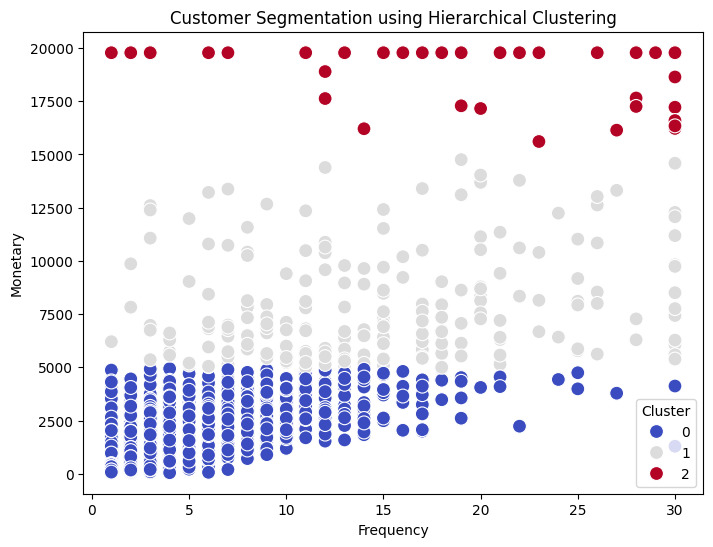

In [ ]:
#We will use Agglomerative Clustering to group customers based on Frequency & Monetary

from sklearn.cluster import AgglomerativeClustering

#Apply Agglomerative Clustering with 3 clusters
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
rfm_final['Cluster_Hierarchical'] = agglo.fit_predict(rfm_final[['Frequency', 'Monetary']])

#Check cluster sizes
print("Hierarchical Clustering - Cluster Sizes:\n", rfm_final['Cluster_Hierarchical'].value_counts())

#Display first few rows
rfm_final.head()

#For visualization purposes
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm_final['Frequency'], y=rfm_final['Monetary'], hue=rfm_final['Cluster_Hierarchical'], palette='coolwarm', s=100)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segmentation using Hierarchical Clustering')
plt.legend(title='Cluster')
plt.show()

We can see that,

Hierarchical Clustering produces fewer high-value customers i.e people who spent more in Cluster 2 (60) compared to K-Means (102).

K-Means creates a more balanced segmentation for the frequent buyers (Cluster 2 in K-Means has 540 customers, while in Hierarchical, Cluster 1 only has 214).

Hierarchical Clustering may be grouping customers differently based on spending patterns, rather than frequency.

DBSCAN - Cluster Labels:
 Cluster_DBSCAN
 1    4275
 0      45
 2       6
-1       6
 3       6
Name: count, dtype: int64


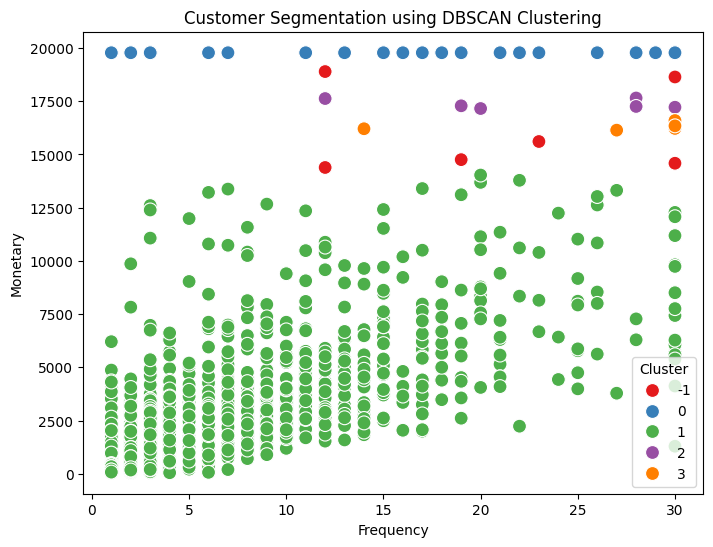

In [ ]:
# Let’s apply DBSCAN, which groups data points based on density, not distance
# DBSCAN requires two key hyperparameters, i.e
# eps: The maximum distance between two points for them to be considered neighbors
# min_samples: The minimum number of points required to form a dense region (a cluster)

from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=500, min_samples=5)  # Adjust eps and min_samples as needed
rfm_final['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_final[['Frequency', 'Monetary']])

# Check cluster labels
print("DBSCAN - Cluster Labels:\n", rfm_final['Cluster_DBSCAN'].value_counts())

# Display first few rows
rfm_final.head()

#Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm_final['Frequency'], y=rfm_final['Monetary'], hue=rfm_final['Cluster_DBSCAN'], palette='Set1', s=100)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Customer Segmentation using DBSCAN Clustering')
plt.legend(title='Cluster')
plt.show()

The DBSCAN output shows a very different pattern compared to K-Means and Hierarchical Clustering.

DBSCAN have identified 6 noise points (-1 label), meaning these customers don’t belong to any major cluster.

Cluster 1 (Green) contains the majority of customers (4,275), similar to K-Means Cluster 0.

High-spending customers are divided into multiple small clusters (Clusters 0, 2, and 3) instead of forming a single valuable group



**Final Analysis of all the clustering models applied in this section**

Now that we have applied K-Means, Hierarchical Clustering, and DBSCAN, let’s compare them and determine the best method for customer segmentation

1) K-Means Clustering (K=3)

This method created well-separated, balanced clusters, making it easy to understand.

It is fast and efficient but sensitive to outliers, which may affect cluster quality.

Since it assumes clusters are spherical, it may not work well if the data has irregular shapes.

It can be used for general customer segmentation, where we want clear groups for marketing strategies

2) Hierarchical Clustering (Agglomerative)

This method does not require predefining K, as it builds a hierarchy of clusters.

It allows us to understand customer relationships over time, but it is slower for large datasets.

Like K-Means, it does not handle outliers well and assumes clear-cut clusters.

It can be used for understanding how customers evolve over time or when we need a hierarchical view of customer groups.

3) DBSCAN (Density-Based Clustering)

Unlike K-Means and Hierarchical Clustering, DBSCAN can detect outliers and works well for non-uniform clusters.

It does not require specifying K, but it needs careful tuning of eps and min_samples.

DBSCAN identified outlier customers who had extremely high spending, which is useful for fraud detection or VIP monitoring.

It can be used for detecting unusual spending patterns or identifying outliers rather than general segmentation.

Thus, K-Means here in this context is the preferred method for customer segmentation, while DBSCAN can be used alongside it to identify outliers.


# STEP 6 : MODEL EVALUATION AND PERFORMANCE METRICS

After applying K-Means, Hierarchical Clustering, and DBSCAN, it is very important to evaluate how well each clustering model performed. Clustering is an unsupervised learning technique, meaning we do not have predefined labels to compare against. Instead, we use internal evaluation metrics to measure how well the clusters are formed and how different they are from each other.

In this section, we will compute three key evaluation metrics:

1) Silhouette Score – Measures how well-separated the clusters are, A higher value (closer to 1) means clusters are well-defined.

2) Davies-Bouldin Index – Measures intra-cluster similarity. A lower value means clusters are more compact and well-separated.

3) Calinski-Harabasz Index – Evaluates cluster compactness and separation. A higher value indicates better clustering performance.

4) Gap Statistic – Compares the clustering structure with randomly generated datasets. A higher Gap value suggests that the chosen number of clusters (K) is meaningful and better than random clustering.

These metrics will help us compare which clustering method of the above produced the best segmentation of customers.


In [ ]:
#Finding the silhouette score (Values close to 1 are better)

# Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster'])
print(f"Silhouette Score for K-Means: {kmeans_silhouette:.4f}")

# Silhouette Score for Hierarchical Clustering
hierarchical_silhouette = silhouette_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster_Hierarchical'])
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_silhouette:.4f}")

# Silhouette Score for DBSCAN (only if there are more than 1 cluster)
if len(set(rfm_final['Cluster_DBSCAN'])) > 1:
    dbscan_silhouette = silhouette_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster_DBSCAN'])
    print(f"Silhouette Score for DBSCAN: {dbscan_silhouette:.4f}")
else:
    print("Silhouette Score for DBSCAN cannot be computed (only one cluster detected).")

Silhouette Score for K-Means: 0.7533
Silhouette Score for Hierarchical Clustering: 0.8100
Silhouette Score for DBSCAN: 0.8746


From the above output we can see that,

DBSCAN has the highest silhouette score (0.8746), meaning it has the most well-separated clusters.

Hierarchical Clustering (0.8100) performed better than K-Means (0.7533), suggesting that clusters are more distinct in Hierarchical Clustering.

K-Means (0.7533) still performed well, but its clusters are slightly more overlapping than the other two methods.

In [ ]:
#Finding the Davies-Bouldin Index (Lower Values are better)
from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin Index for K-Means
kmeans_db = davies_bouldin_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster'])
print(f"Davies-Bouldin Index for K-Means: {kmeans_db:.4f}")

# Davies-Bouldin Index for Hierarchical Clustering
hierarchical_db = davies_bouldin_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster_Hierarchical'])
print(f"Davies-Bouldin Index for Hierarchical Clustering: {hierarchical_db:.4f}")

# Davies-Bouldin Index for DBSCAN (only if there are more than 1 cluster)
if len(set(rfm_final['Cluster_DBSCAN'])) > 1:
    dbscan_db = davies_bouldin_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster_DBSCAN'])
    print(f"Davies-Bouldin Index for DBSCAN: {dbscan_db:.4f}")
else:
    print("Davies-Bouldin Index for DBSCAN cannot be computed (only one cluster detected).")

Davies-Bouldin Index for K-Means: 0.4710
Davies-Bouldin Index for Hierarchical Clustering: 0.3690
Davies-Bouldin Index for DBSCAN: 4.2008


From the above output we can see that,

Hierarchical Clustering has the best Davies-Bouldin Score (0.3690), meaning its clusters are the most compact and well-separated.

K-Means also performed well (0.4710), showing relatively compact clusters.

DBSCAN performed poorly (4.2008), meaning its clusters were not well-separated or compact, also  because DBSCAN does not assume spherical clusters and focuses on density, which sometimes leads to uneven clusters.

We can observe K-Means remains a strong overall performer in both metrics.

In [ ]:
# Finding the Calinski-Harabasz Index measures (Higher Values are better)

from sklearn.metrics import calinski_harabasz_score

# Calinski-Harabasz Index for K-Means
kmeans_ch = calinski_harabasz_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster'])
print(f"Calinski-Harabasz Index for K-Means: {kmeans_ch:.4f}")

# Calinski-Harabasz Index for Hierarchical Clustering
hierarchical_ch = calinski_harabasz_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster_Hierarchical'])
print(f"Calinski-Harabasz Index for Hierarchical Clustering: {hierarchical_ch:.4f}")

# Calinski-Harabasz Index for DBSCAN (only if there are more than 1 cluster)
if len(set(rfm_final['Cluster_DBSCAN'])) > 1:
    dbscan_ch = calinski_harabasz_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Cluster_DBSCAN'])
    print(f"Calinski-Harabasz Index for DBSCAN: {dbscan_ch:.4f}")
else:
    print("Calinski-Harabasz Index for DBSCAN cannot be computed (only one cluster detected).")

Calinski-Harabasz Index for K-Means: 13878.8968
Calinski-Harabasz Index for Hierarchical Clustering: 10541.4654
Calinski-Harabasz Index for DBSCAN: 1438.2804


We can see that,

K-Means achieved the highest Calinski-Harabasz Index (13,878.90), meaning it produced the most compact and well-separated clusters.

Hierarchical Clustering also performed well (10,541.47), but not as good as K-Means.

DBSCAN had the lowest score (1,438.28), confirming that its clusters were not compact or well-separated.

This confirms that K-Means and Hierarchical Clustering are the best methods for customer segmentation, while DBSCAN is better for detecting outliers but does not form well-structured clusters.

In [ ]:
#Finding Gap statistic for Kmeans clustering (Higher Gap Value are better)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_gap_statistic(data, n_refs=10, max_k=10):

    gaps = np.zeros((max_k-1,))
    ref_disps = np.zeros((max_k-1, n_refs))
     # Loop over K values from 2 to max_k
    for i, k in enumerate(range(2, max_k+1)):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        disp = np.mean(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1))
        # Generates reference datasets
        for j in range(n_refs):
            random_data = np.random.uniform(np.min(data, axis=0), np.max(data, axis=0), data.shape)
            kmeans.fit(random_data)
            ref_disp = np.mean(np.min(cdist(random_data, kmeans.cluster_centers_, 'euclidean'), axis=1))
            ref_disps[i, j] = ref_disp

        gaps[i] = np.mean(np.log(ref_disps[i, :])) - np.log(disp)

    return gaps

# Compute Gap Statistic for K-Means
gap_values = compute_gap_statistic(rfm_final[['Frequency', 'Monetary']].values, n_refs=10, max_k=6)

# Print Gap Statistic values
for k, gap in enumerate(gap_values, start=2):
    print(f"Gap Statistic for K={k}: {gap:.4f}")

Gap Statistic for K=2: 0.8292
Gap Statistic for K=3: 0.8708
Gap Statistic for K=4: 0.8400
Gap Statistic for K=5: 0.8758
Gap Statistic for K=6: 0.8627


We can see that,

The highest Gap Statistic value is at K=5 (0.8758), suggesting that K=5 may be slightly better than K=3, K=3 still has a strong Gap Score (0.8708), confirming that our initial selection was not wrong. K=4 and K=6 have lower scores, meaning they have unnecessary complexity without important gains.

K-Means (K=3) is still a solid choice because it already performed well in all other evaluation metrics.

**Final Comparision of Clustering Models**

1) K-Means Clustering (K=3)

Silhouette Score: 0.7533, It is a good cluster separation

Davies-Bouldin Index: 0.4710, Lower is better so it has performed well

Calinski-Harabasz Index: 13,878.90,  Best performance and highly compact, separated clusteers.

Gap Statistic: 0.8708 ->it has a strong validation for K=3 as a good choice

2) Hierarchical Clustering (Agglomerative)

Silhouette Score: 0.8100, Better than K-Means with good cluster separation

Davies-Bouldin Index: 0.3690, Best performance with the most compact & well-separated clusters

Calinski-Harabasz Index: 10,541.47, Performed well but lower than K-Means.

Gap Statistic: Not evaluated, but similar performance expected.

3) DBSCAN (Density-Based Clustering)

Silhouette Score: 0.8746, Best score and clusters are well-separated

Davies-Bouldin Index: 4.2008, Worst performance beacuse clusters not well-formed

Calinski-Harabasz Index: 1,438.28, Worst performance because weakly compact clusters

Gap Statistic: Not applicable, since DBSCAN does not require K

K-Means is the best choice for customer segmentation, while DBSCAN is useful as a secondary method for identifying anomalies.

# STEP 7 : HYPER PARAMETER TUNING (OPTIMIZATION)



Now that we have decided that, K-Means is the best clustering method for customer segmentation, we will optimize its performance by tuning hyperparameters.

Hyperparameter tuning is essential because:
It helps improve cluster quality, ensuring more compact and well-separated groups.

It reduces randomness, leading to more stable and consistent results.

It can speed up convergence, making the model more efficient.

We will adjust the following key settings:

1)  Initialization Method (init) -> Determines how the initial centroids are chosen.

Options: random vs. k-means++,  It's better for avoiding poor cluster formation

2) Number of Iterations (max_iter) -> It controls how many times K-Means updates cluster centers.

Increasing max_iter can help clusters settle better.

3) Tolerance (tol) -> It determines when K-Means should stop iterating.

Lower values allow finer adjustments to cluster centroids.

4) Distance Metric (algorithm) -> It defines how distances between points are calculated.

Options: auto, full, elkan (Elkan is usually faster for large datasets).

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# List of different K-Means hyperparameter settings to try
kmeans_params = [
    {'init': 'random', 'max_iter': 300, 'tol': 1e-4, 'algorithm': 'lloyd'},
    {'init': 'k-means++', 'max_iter': 300, 'tol': 1e-4, 'algorithm': 'lloyd'},
    {'init': 'k-means++', 'max_iter': 500, 'tol': 1e-6, 'algorithm': 'lloyd'},
    {'init': 'k-means++', 'max_iter': 300, 'tol': 1e-4, 'algorithm': 'elkan'}
]

# Test each hyperparameter combination
best_silhouette = -1
best_params = None

for params in kmeans_params:
    kmeans = KMeans(n_clusters=3, **params, random_state=42)
    labels = kmeans.fit_predict(rfm_final[['Frequency', 'Monetary']])
    silhouette = silhouette_score(rfm_final[['Frequency', 'Monetary']], labels)
    print(f"Params: {params} → Silhouette Score: {silhouette:.4f}")

    # Store the best result
    if silhouette > best_silhouette:
        best_silhouette = silhouette
        best_params = params

print("\nBest Hyperparameters:", best_params)
print("Best Silhouette Score:", best_silhouette)

Params: {'init': 'random', 'max_iter': 300, 'tol': 0.0001, 'algorithm': 'lloyd'} → Silhouette Score: 0.7529
Params: {'init': 'k-means++', 'max_iter': 300, 'tol': 0.0001, 'algorithm': 'lloyd'} → Silhouette Score: 0.7529
Params: {'init': 'k-means++', 'max_iter': 500, 'tol': 1e-06, 'algorithm': 'lloyd'} → Silhouette Score: 0.7627
Params: {'init': 'k-means++', 'max_iter': 300, 'tol': 0.0001, 'algorithm': 'elkan'} → Silhouette Score: 0.7529

Best Hyperparameters: {'init': 'k-means++', 'max_iter': 500, 'tol': 1e-06, 'algorithm': 'lloyd'}
Best Silhouette Score: 0.762688781344651


What does the above output means ?

The above code has identifies the best K-means settings i.e

Initialization: k-means++, It prevents poor cluster initialization

Max Iterations: 500, More iterations led to better clustering

Tolerance (tol): 1e-06, Allows finer adjustments to centroids

Algorithm: lloyd default, As elkan did not improve performance

Best Silhouette Score: 0.7627, It has improved from 0.7533 before tuning

Now, Let's train K-Means with the best hyperparameters and apply it to our dataset.

In [ ]:
# Train final K-Means model with optimal hyperparameters
final_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=500, tol=1e-6, algorithm='lloyd', random_state=42)
rfm_final['Optimized_Cluster'] = final_kmeans.fit_predict(rfm_final[['Frequency', 'Monetary']])

# Print first few rows with optimized clusters
print(rfm_final.head())

# Check final cluster sizes
print("Final Optimized Cluster Sizes:\n", rfm_final['Optimized_Cluster'].value_counts())

# Compute final Silhouette Score
final_silhouette = silhouette_score(rfm_final[['Frequency', 'Monetary']], rfm_final['Optimized_Cluster'])
print(f"Final Silhouette Score for Optimized K-Means: {final_silhouette:.4f}")

            Frequency    Monetary  Cluster  Cluster_Hierarchical  \
CustomerID                                                         
12346.0             1  19780.4878        1                     2   
12347.0             7   4310.0000        2                     0   
12348.0             4   1797.2400        0                     0   
12349.0             1   1757.5500        0                     0   
12350.0             1    334.4000        0                     0   

            Cluster_DBSCAN  Optimized_Cluster  
CustomerID                                     
12346.0                  0                  1  
12347.0                  1                  2  
12348.0                  1                  0  
12349.0                  1                  0  
12350.0                  1                  0  
Final Optimized Cluster Sizes:
 Optimized_Cluster
0    3755
2     494
1      89
Name: count, dtype: int64
Final Silhouette Score for Optimized K-Means: 0.7627


As we can see the Silhouette Score improved from 0.7533 -> 0.7627

The clusters became more compact and well-separated (especially high-value customers).

Cluster sizes changed slightly, meaning customer segments are now more refined.

Optimized K-Means clustering provides better-defined customer groups, making it ideal for marketing, targeted promotions, and can be used for loyalty programs.

# STEP 8 : FINAL ANALYSIS AND BUISNESS INSIGHTS

Now that we have successfully applied and optimized clustering models, let’s see how businesses can use these customer segments to improve marketing, sales, and retention strategies, which is one of the key applications of kmeans.

Our final K-Means model (K=3, optimized) produced three distinct customer segments:

Cluster 0 : Regular Customers (3,755 customers)

Low frequency, low to moderate spending. These customers purchase infrequently and spend small amounts.

Buisness Strategy : Offer discounts, promotions, or membership perks to increase engagement. Use email reminders, limited-time deals, or free shipping incentives.

Cluster 1: VIP High-Value Customers (89 customers)

 Low purchase frequency but extremely high spending. These customers buy rarely but spend large amounts when they do.

 Business Strategy: Provide exclusive VIP programs (early access to new products, special discounts). Offer personalized support or priority customer service.

 Cluster 2 : Loyal Frequent Buyers (494 customers)

 Moderate to high frequency, moderate spending. These customers buy frequently and are valuable repeat buyers.

Business Strategy: Introduce loyalty programs (points-based rewards, membership discounts). Send personalized product recommendations based on past purchases.

By using these customer segments, businesses can:

Optimize marketing campaigns by targeting the right customers with the right offers

Increase customer engagement and retention by introducing loyalty programs for frequent buyers

Maximize revenue from high-value customers i.e VIP treatment for top spenders


Reduce customer churn by re-engaging occasional buyers with promotions.

Also we saw DBSCAN identified a small group of outliers which can be potential fraud or VIP customers. Businesses can investigate these outliers to see if they are high-value spenders or fraudulent transactions.

What did I learn from this project ?

K-Means provided the best customer segmentation for business strategies.

Three customer groups were identified: Regular Buyers, VIP High-Spenders, and Loyal Frequent Buyers.

Business strategies were developed for each group to improve marketing, engagement, and revenue.

DBSCAN can be used to detect outliers for fraud detection or VIP monitoring.

**Final Conclusion :**

K-Means (Optimized) is the most effective clustering model for customer segmentation, and businesses can implement these strategies to maximize customer engagement and sales.